In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%pip install pandas-summary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


# 과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안

주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요.

In [ ]:
from pro1 import df_order, df_sellers, df_order_items, df_join_order_cp, df_order_reviews, 

# from pro1 import df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_products, df_sellers

In [5]:
# --- 1) delivered 상태만 필터 ---
df = df_join_order_cp[df_join_order_cp["order_status"]=="delivered"].copy()

# --- 2) 단계별 평균 배송시간 ---
step_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]
step_mean = df[step_cols].mean().round(2)

print("📌 단계별 평균 배송시간(일 단위)")
print(step_mean)

# --- 3) ETA 대비 지연일 계산 ---
# ETA는 날짜만 저장된 경우가 많아 date 단위 비교 권장
df["delay_days"] = (df["order_delivered_customer_date"].dt.floor("d") - 
                    df["order_estimated_delivery_date"].dt.floor("d")).dt.days

# 정시/지연 여부
df["on_time"] = df["delay_days"] <= 0

# KPI 요약
total = len(df)
on_time = df["on_time"].sum()
late = total - on_time
kpi = {
    "총 배송건수": total,
    "정시배송율": round(on_time/total*100,2),
    "지연배송율": round(late/total*100,2),
    "평균 지연일(지연건만)": round(df.loc[df["delay_days"]>0,"delay_days"].mean(),2)
}
print("\n📌 ETA 대비 KPI")
print(pd.Series(kpi))

# --- 4) 지연 구간 분포 ---
bins = [-np.inf,0,3,7,14,30,np.inf]
labels = ["정시/조기","1-3일 지연","3-7일 지연","7-14일 지연","14-30일 지연","30일 초과"]
delay_dist = pd.cut(df["delay_days"], bins=bins, labels=labels).value_counts(normalize=True).sort_index()
delay_dist = (delay_dist*100).round(2).astype(str) + "%"
print("\n📌 지연 구간 분포")
print(delay_dist)

📌 단계별 평균 배송시간(일 단위)
purchase_to_approved     0.21
approved_to_carrier      2.22
carrier_to_customer      7.87
purchase_to_customer    10.30
dtype: float64

📌 ETA 대비 KPI
총 배송건수          77691.00
정시배송율              97.99
지연배송율               2.01
평균 지연일(지연건만)        3.45
dtype: float64

📌 지연 구간 분포
delay_days
정시/조기        97.99%
1-3일 지연       1.21%
3-7일 지연       0.67%
7-14일 지연      0.13%
14-30일 지연     0.01%
30일 초과         0.0%
Name: proportion, dtype: object


In [6]:
# --- 1) delivered 상태만 필터 ---
df = df_join_order_cp[df_join_order_cp["order_status"]=="delivered"].copy()

# --- 2) ETA 대비 지연일 ---
df["delay_days"] = (df["order_delivered_customer_date"].dt.floor("d") - 
                    df["order_estimated_delivery_date"].dt.floor("d")).dt.days
df["on_time"] = df["delay_days"] <= 0

# --- 3) 지역별 성과 집계 ---
region_metrics = df.groupby("customer_city").agg(
    주문수 = ("order_id","count"),
    평균_승인까지 = ("purchase_to_approved","mean"),
    평균_승인_배송사 = ("approved_to_carrier","mean"),
    평균_배송사_고객 = ("carrier_to_customer","mean"),
    평균_전체배송 = ("purchase_to_customer","mean"),
    정시배송율 = ("on_time","mean"),
    평균_지연일 = ("delay_days", lambda x: x[x>0].mean())
).reset_index()

# 퍼센트 변환
region_metrics["정시배송율"] = (region_metrics["정시배송율"]*100).round(2)
region_metrics = region_metrics.round(2)

# --- 4) 상위/하위 지역 확인 (주문건수 기준 필터링) ---
# 너무 주문수가 적은 지역은 신뢰도가 낮으므로, 예: 50건 이상만
region_metrics_filtered = region_metrics[region_metrics["주문수"] >= 50]

# 정시배송율 Top 10
top10 = region_metrics_filtered.sort_values("정시배송율", ascending=False).head(10)

# 정시배송율 Bottom 10
bottom10 = region_metrics_filtered.sort_values("정시배송율", ascending=True).head(10)

print("\n📌 지역별 배송 성과 (샘플 5행)")
print(region_metrics_filtered.head())

print("\n📌 정시배송율 Top 10 지역")
print(top10[["customer_city","주문수","평균_전체배송","정시배송율","평균_지연일"]])

print("\n📌 정시배송율 Bottom 10 지역")
print(bottom10[["customer_city","주문수","평균_전체배송","정시배송율","평균_지연일"]])

'''
물류 최적화 방안
배송 성과 좋은 지역: São Paulo, Campinas → 물류 인프라 발달
배송 성과 낮은 지역: Recife, Manaus, Salvador → 장거리 물류/항공 운송 필요

빠진 데이터 확인!!!!!!!!!
merge 과정에서 order_id 기준 데이터가 빠짐 → 즉, 배송일자(order_delivered_customer_date)가 없는 주문.

지역별 groupby 후 데이터가 없는 그룹 → 특정 지역은 주문은 있으나 배송완료 정보가 없음.

👉 확인하려면 다음 코드 실행해보세요:
print(df_region_delivery[['평균_전체배송','정시배송율','지연배송율']].isnull().sum())

'''



📌 지역별 배송 성과 (샘플 5행)
      customer_city  주문수  평균_승인까지  평균_승인_배송사  평균_배송사_고객  평균_전체배송  정시배송율  \
137       americana  186     0.19       2.18       4.74     7.12  95.16   
143          amparo   55     0.23       2.05       6.07     8.36  98.18   
149      ananindeua   55     0.18       2.38      14.98    17.53  98.18   
150        anapolis   87     0.26       2.06      12.58    14.90  98.85   
169  angra dos reis   60     0.23       2.35      10.63    13.22  95.00   

     평균_지연일  
137    2.78  
143    2.00  
149    3.00  
150    1.00  
169    3.33  

📌 정시배송율 Top 10 지역
        customer_city  주문수  평균_전체배송  정시배송율  평균_지연일
289             aruja   62     6.44  100.0     NaN
406             belem  274    16.36  100.0     NaN
380          barretos   55     9.53  100.0     NaN
347         barbacena   67    10.94  100.0     NaN
294             assis   74     9.21  100.0     NaN
408      belford roxo   87    11.46  100.0     NaN
1341         gravatai   95    13.33  100.0     NaN
1264  franco da r

"\n물류 최적화 방안\n배송 성과 좋은 지역: São Paulo, Campinas → 물류 인프라 발달\n배송 성과 낮은 지역: Recife, Manaus, Salvador → 장거리 물류/항공 운송 필요\n\n빠진 데이터 확인!!!!!!!!!\nmerge 과정에서 order_id 기준 데이터가 빠짐 → 즉, 배송일자(order_delivered_customer_date)가 없는 주문.\n\n지역별 groupby 후 데이터가 없는 그룹 → 특정 지역은 주문은 있으나 배송완료 정보가 없음.\n\n👉 확인하려면 다음 코드 실행해보세요:\nprint(df_region_delivery[['평균_전체배송','정시배송율','지연배송율']].isnull().sum())\n\n"

In [7]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


2. 고객 리뷰와 배송 지연 영향 분석

지역별 배송 성과 (평균 배송일수, 정시율, 지연율)
배송 지연 → 리뷰 점수 하락 여부

          mean  count
지연여부                 
0     4.320860  75360
1     3.335619   2333


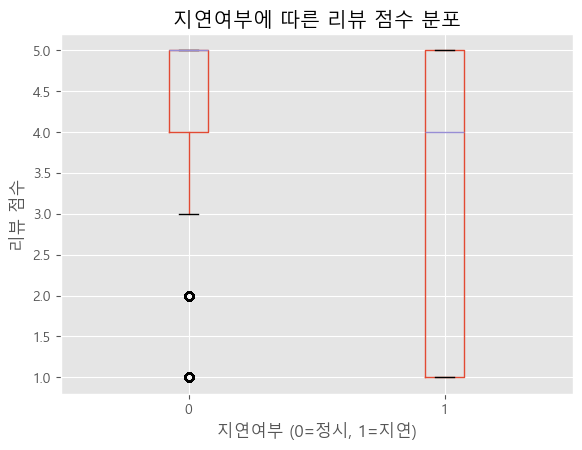

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\493010998.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='지연여부', y='review_score', data=df_review_merge, palette='pastel')


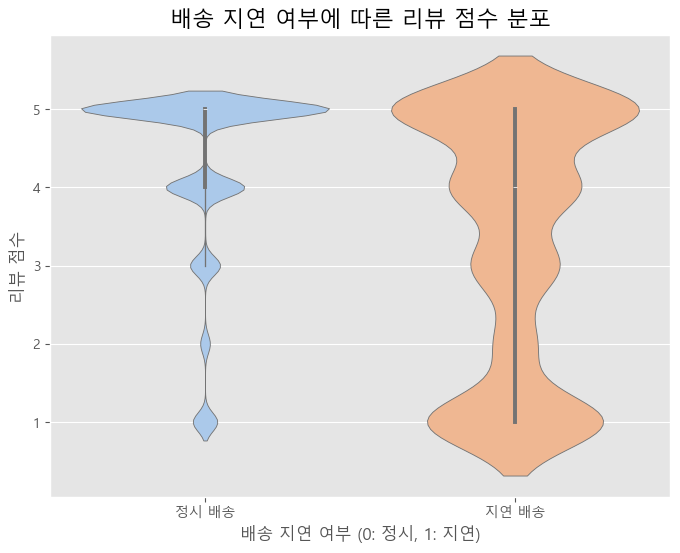

In [ ]:
# 1. 배송 지연 여부 계산
df_join_order_cp['지연여부'] = (
    df_join_order_cp['order_delivered_customer_date'] >
    df_join_order_cp['order_estimated_delivery_date']
).astype(int)  # 1 = 지연, 0 = 정시

# 2. 리뷰 데이터와 주문 데이터 병합
df_review_merge = df_join_order_cp[['order_id','지연여부']].merge(
    df_order_reviews[['order_id','review_score']],
    on='order_id', how='inner'
)

# 3. 지연 여부에 따른 리뷰 점수 비교
review_stats = df_review_merge.groupby('지연여부')['review_score'].agg(['mean','count'])
print(review_stats)


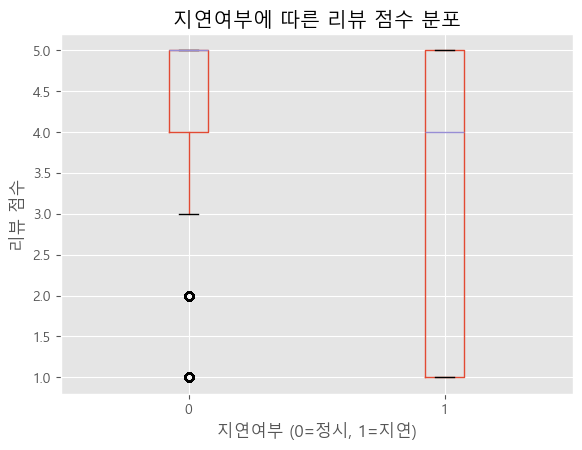

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='지연여부', y='review_score', data=df_review_merge, palette='pastel')


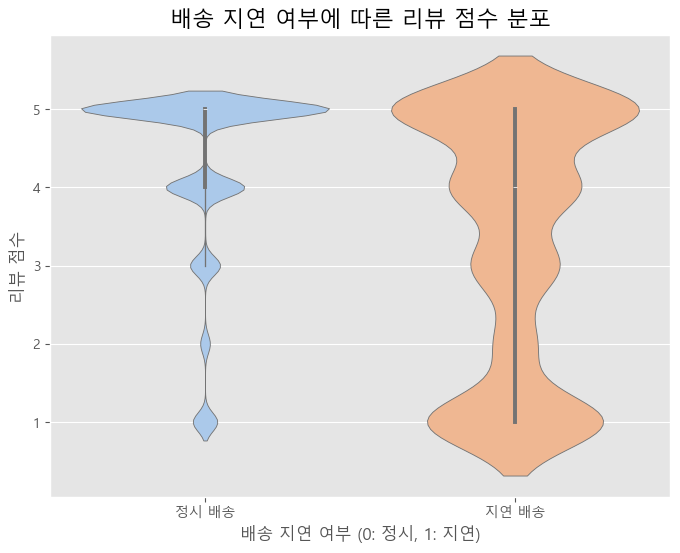

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='정시배송율', y='customer_city', data=top10, palette='viridis')


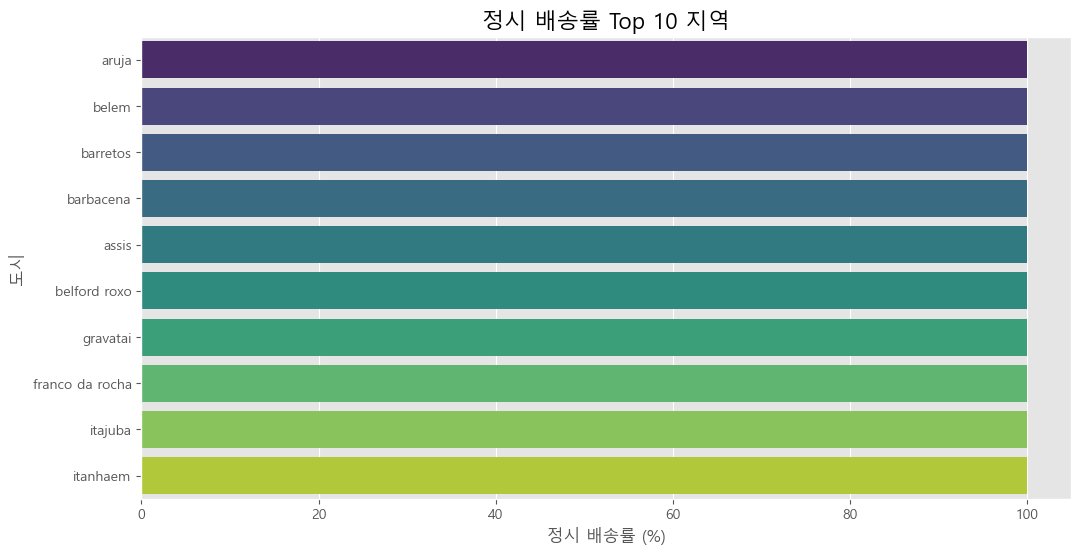

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='정시배송율', y='customer_city', data=bottom10, palette='plasma')


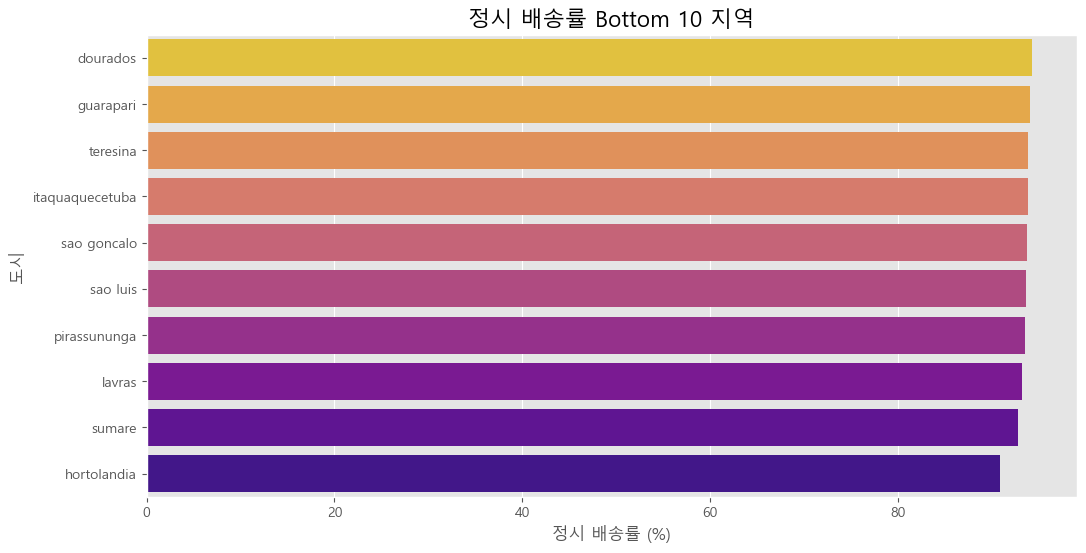

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='평균_전체배송', y='customer_city', data=bottom10, palette='magma')


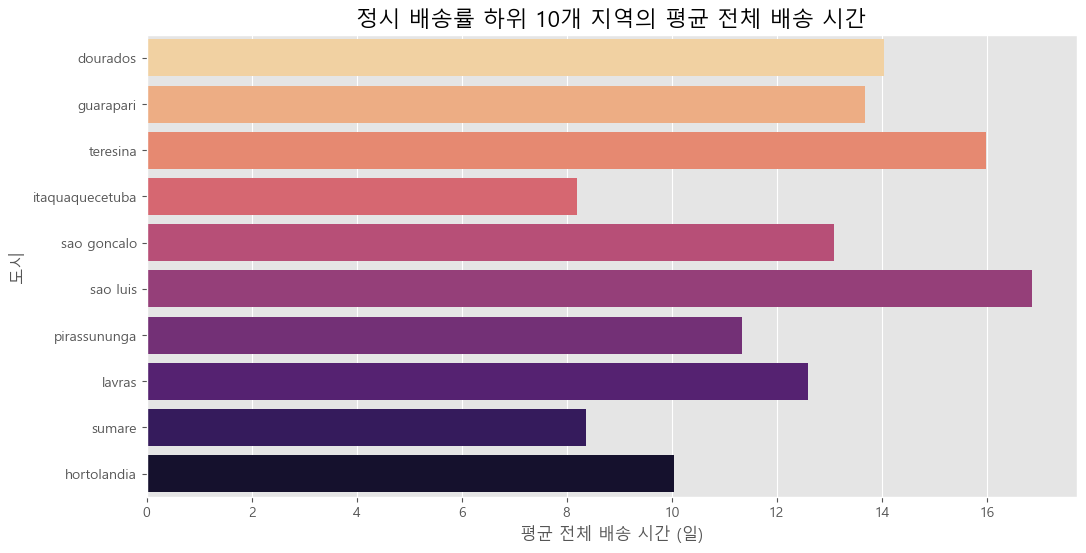

In [11]:
plt.rc('font', family='Malgun Gothic') # 폰트 설정 (Mac: 'AppleGothic', Windows: 'Malgun Gothic')
plt.style.use('ggplot')

# 4. 시각화
df_review_merge.boxplot(column='review_score', by='지연여부')
plt.title("지연여부에 따른 리뷰 점수 분포")
plt.suptitle("")
plt.xlabel("지연여부 (0=정시, 1=지연)")
plt.ylabel("리뷰 점수")
plt.show()

# 지연 여부(0=정시, 1=지연)에 따른 리뷰 점수 분포 시각화
plt.figure(figsize=(8, 6))
sns.violinplot(x='지연여부', y='review_score', data=df_review_merge, palette='pastel')
plt.title('배송 지연 여부에 따른 리뷰 점수 분포', fontsize=16)
plt.xlabel('배송 지연 여부 (0: 정시, 1: 지연)', fontsize=12)
plt.ylabel('리뷰 점수', fontsize=12)
plt.xticks([0, 1], ['정시 배송', '지연 배송'])
plt.show()

# 정시배송율 Top 10 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='정시배송율', y='customer_city', data=top10, palette='viridis')
plt.title('정시 배송률 Top 10 지역', fontsize=16)
plt.xlabel('정시 배송률 (%)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.show()

# 정시배송율 Bottom 10 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='정시배송율', y='customer_city', data=bottom10, palette='plasma')
plt.title('정시 배송률 Bottom 10 지역', fontsize=16)
plt.xlabel('정시 배송률 (%)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.gca().invert_yaxis() # y축 순서 뒤집기
plt.show()

# 지역별 평균 전체 배송 시간 시각화 (정시배송률 하위 10개 지역)
plt.figure(figsize=(12, 6))
sns.barplot(x='평균_전체배송', y='customer_city', data=bottom10, palette='magma')
plt.title('정시 배송률 하위 10개 지역의 평균 전체 배송 시간', fontsize=16)
plt.xlabel('평균 전체 배송 시간 (일)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.gca().invert_yaxis()
plt.show()